# Implementing a Neural Network - An Introduction

In this post we will implement a simple 3-layer neural network from scratch. We won't derive all the math that's required, but will try to give an intuitive explanation of what we are doing and will point to resources to read up on the details.

This notebook assumes familiarity with basic Calculus and Machine Learning concepts, e.g. you know what classification and regularization is. Ideally you also know a bit about how optimization techniques like gradient descent work. But even if you're not familiar with any of the above this post could still turn out to be interesting ;)

Reference: https://github.com/dennybritz/nn-from-scratch


In [1]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

# Display plots inline and change default figure size
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Generating a dataset

Let's start by generating a dataset we can play with. Fortunately, [scikit-learn](http://scikit-learn.org/) has some useful dataset generators, so we don't need to write the code ourselves. We will go with the [`make_moons`](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) function.

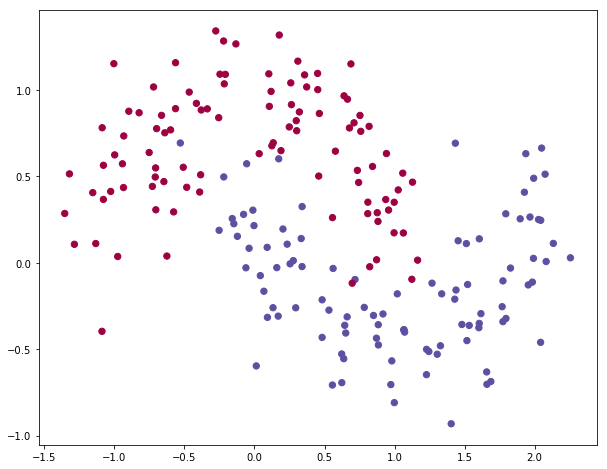

In [2]:
# Generate a dataset and plot it
np.random.seed(0)
X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

The dataset we generated has two classes, plotted as red and blue points. You can think of the blue dots as male patients and the red dots as female patients, with the x- and y- axis being medical measurements. 

Our goal is to train a Machine Learning classifier that predicts the correct class (male or female) given the x- and y- coordinates. Note that the data is not *linearly separable*, we can't draw a straight line that separates the two classes. This means that linear classifiers, such as Logistic Regression, won't be able to fit the data unless you hand-engineer non-linear features (such as polynomials) that work well for the given dataset.

In fact, that's one of the major advantages of Neural Networks. The hidden layer of a neural network will learn features for you.

## Logistic Regression

To demonstrate the point let's train a Logistic Regression classifier. It's input will be the x- and y-values and the output the predicted class (0 or 1). To make our life easy we use the Logistic Regression class from `scikit-learn`.

In [3]:
# Train the logistic regeression classifier
clf = sklearn.linear_model.LogisticRegressionCV()
clf.fit(X, y)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
# Helper function to plot a decision boundary.
# If you don't fully understand this function don't worry, it just generates the contour plot below.
def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

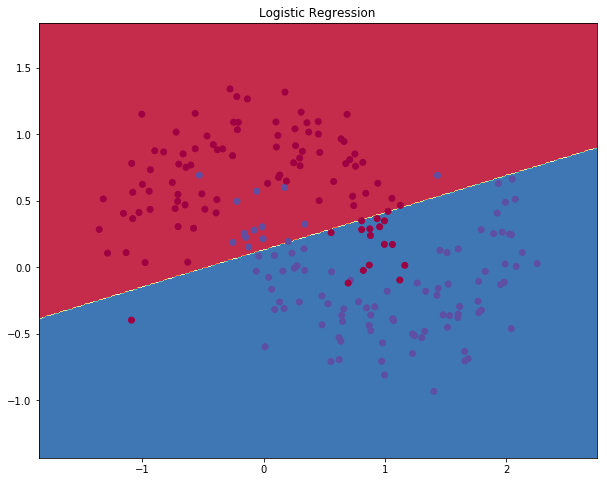

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: clf.predict(x))
plt.title("Logistic Regression")

The graph shows the decision boundary learned by our Logistic Regression classifier. It separates the data as good as it can using a straight line, but it's unable to capture the "moon shape" of our data.

## Training a Neural Network

Let's now build a 3-layer neural network with one input layer, one hidden layer, and one output layer. The number of nodes in the input layer is determined by the dimensionality of our data, 2. Similarly, the number of nodes in the output layer is determined by the number of classes we have, also 2. (Because we only have 2 classes we could actually get away with only one output node predicting 0 or 1, but having 2 makes it easier to extend the network to more classes later on). The input to the network will be x- and y- coordinates and its output will be two probabilities, one for class 0 ("female") and one for class 1 ("male"). It looks something like this:

<img src='./nn-3-layer-network.png' style='width: 50%'/>

We can choose the dimensionality (the number of nodes) of the hidden layer. The more nodes we put into the hidden layer the more complex functions we will be able fit. But higher dimensionality comes at a cost. First, more computation is required to make predictions and learn the network parameters. A bigger number of parameters also means we become more prone to overfitting our data. 

How to choose the size of the hidden layer? While there are some general guidelines and recommendations, it always depends on your specific problem and is more of an art than a science. We will play with the number of nodes in the hidden later later on and see how it affects our output.

We also need to pick an *activation function* for our hidden layer. The activation function transforms the inputs of the layer into its outputs. A nonlinear activation function is what allows us to fit nonlinear hypotheses. Common chocies for activation functions are [tanh](https://reference.wolfram.com/language/ref/Tanh.html), the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function), or [ReLUs](https://en.wikipedia.org/wiki/Rectifier_(neural_networks). We will use `tanh`, which performs quite well in many scenarios. A nice property of these functions is that their derivate can be computed using the original function value. For example, the derivative of $\tanh x$ is $1-\tanh^2 x$. This is useful because it allows us to compute $\tanh x$ once and re-use its value later on to get the derivative.

Because we want our network to output probabilities the activation function for the output layer will be the [softmax](https://en.wikipedia.org/wiki/Softmax_function), which is simply a way to convert raw scores to probabilities. If you're familiar with the logistic function you can think of softmax as its generalization to multiple classes.

### Implementation

Now we are ready for our implementation. We start by defining some useful variables and parameters for gradient descent:

In [6]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters (I picked these by hand)
epsilon = 0.01 # learning rate for gradient descent
reg_lambda = 0.01 # regularization strength

First let's implement the loss function we defined above. We use this to evaluate how well our model is doing:

In [7]:
# Helper function to evaluate the total loss on the dataset
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation to calculate our predictions
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    # Calculating the loss
    corect_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(corect_logprobs)
    # Add regulatization term to loss (optional)
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

We also implement a helper function to calculate the output of the network. It does forward propagation as defined above and returns the class with the highest probability.

In [8]:
# Helper function to predict an output (0 or 1)
def predict(model, x):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    # Forward propagation
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

Finally, here comes the function to train our Neural Network. It implements batch gradient descent using the backpropagation derivates we found above.

In [9]:
# This function learns parameters for the neural network and returns the model.
# - nn_hdim: Number of nodes in the hidden layer
# - num_passes: Number of passes through the training data for gradient descent
# - print_loss: If True, print the loss every 1000 iterations
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    
    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        # Assign new parameters to the model
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        if print_loss and i % 1000 == 0:
          print("Loss after iteration %i: %f" %(i, calculate_loss(model)))
    
    return model

### A network with a hidden layer of size 3

Let's see what happens if we train a network with a hidden layer size of 3.


Loss after iteration 0: 0.432387
Loss after iteration 1000: 0.068947
Loss after iteration 2000: 0.068890
Loss after iteration 3000: 0.071218
Loss after iteration 4000: 0.071253
Loss after iteration 5000: 0.071278
Loss after iteration 6000: 0.071293
Loss after iteration 7000: 0.071303
Loss after iteration 8000: 0.071308
Loss after iteration 9000: 0.071312
Loss after iteration 10000: 0.071314
Loss after iteration 11000: 0.071315
Loss after iteration 12000: 0.071315
Loss after iteration 13000: 0.071316
Loss after iteration 14000: 0.071316
Loss after iteration 15000: 0.071316
Loss after iteration 16000: 0.071316
Loss after iteration 17000: 0.071316
Loss after iteration 18000: 0.071316
Loss after iteration 19000: 0.071316


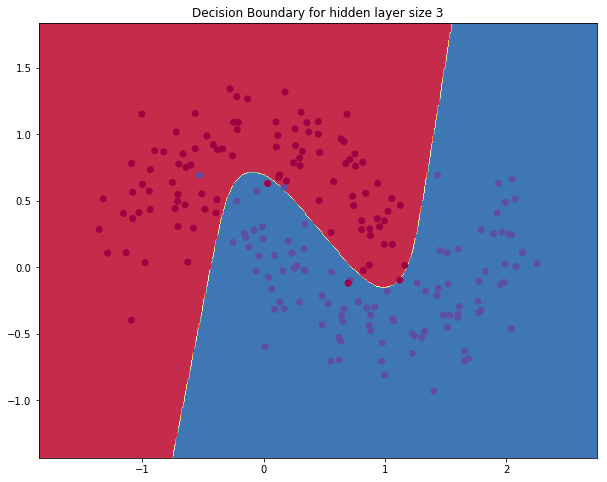

In [10]:
# Build a model with a 3-dimensional hidden layer
model = build_model(3, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Decision Boundary for hidden layer size 3")

This looks pretty good. Our neural networks was able to find a decision boundary that successfully separates the classes.

# Varying the hidden layer size

In the example above we picked a hidden layer size of 3. Let's now get a sense of how varying the hidden layer size affects the result.


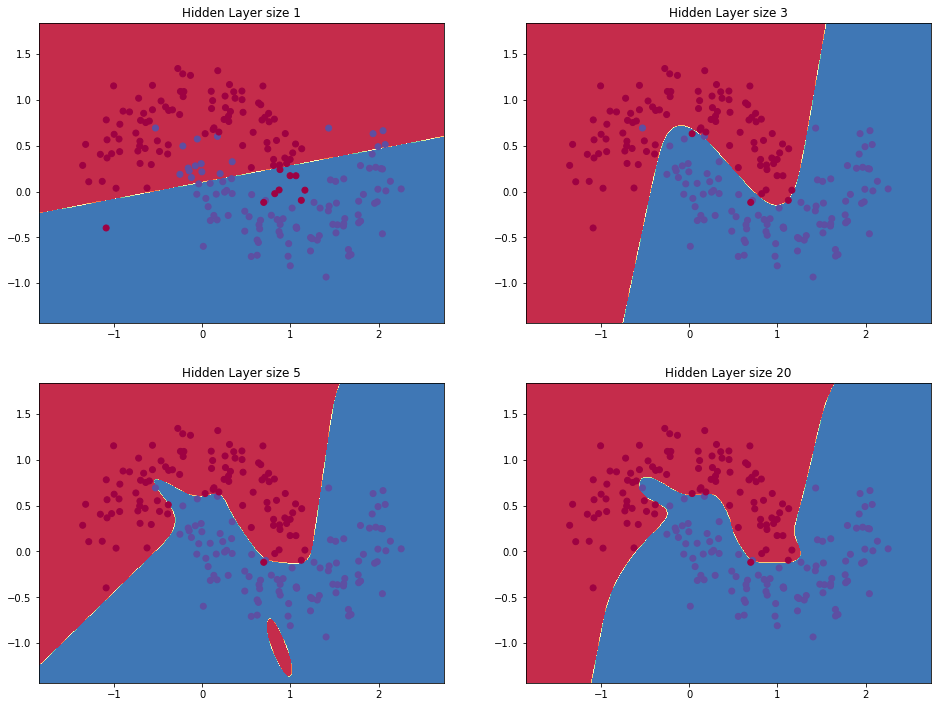

In [11]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1,3,5,20]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer size %d' % nn_hdim)
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda x: predict(model, x))
plt.show()

We can see that while a hidden layer of low dimensionality nicely capture the general trend of our data, but higher dimensionalities are prone to overfitting. They are "memorizing" the data as opposed to fitting the general shape. If we were to evaluate our model on a separate test set (and you should!) the model with a smaller hidden layer size would likely perform better because it generalizes better. We could counteract overfitting with stronger regularization, but picking the a correct size for hidden layer is a much more "economical" solution.